In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt

# loda data

In [2]:
data = loadmat('ex4/ex4data1.mat')
X = data['X']
y = data['y'].flatten().reshape(-1, 1)

data = loadmat('ex4/ex4weights.mat')
theta1 = data['Theta1']
theta2 = data['Theta2']

X.shape, y.shape, theta1.shape, theta2.shape

((5000, 400), (5000, 1), (25, 401), (10, 26))

input layer: 400 + 1
hidden layer: 25 + 1
output layer: 10

# visualizing the data

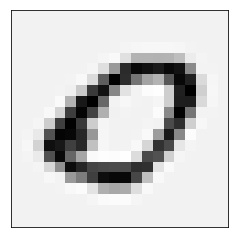

In [3]:
img = X[0]
img = img.reshape(20, 20)

plt.imshow(img, cmap='gray_r')
plt.xticks([])
plt.yticks([])
plt.show()

# preprocessing

In [4]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)

y_onehot.shape

G:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5000, 10)

In [5]:
X = np.insert(X, 0, 1, axis=1)
X.shape

(5000, 401)

# forward

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward(X, theta1, theta2):
    # input layer
    a1 = X
    
    # hidden layer(only)
    z2 = np.dot(a1, theta1.T)
    z2 = sigmoid(z2)
    a2 = np.insert(z2, 0, 1, axis=1) # 25 + 1
    
    # output layer
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3) # h
    
    return a1, z2, a2, z3, a3

In [7]:
a1, z2, a2, z3, h = forward(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

# cost function

In [8]:
def cost(theta1, theta2, X, y):
    _, _, _, _, h = forward(X, theta1, theta2)
    J = (-y * np.log(h)) - ((1 - y) * np.log(1 - h))
    
    return J.sum() / len(X)

def reg_cost(theta1, theta2, X, y, l=0):
    J = cost(theta1, theta2, X, y)
    reg = (l / (2*len(X))) * (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    
    return J + reg

In [9]:
cost(theta1, theta2, X, y_onehot), reg_cost(theta1, theta2, X, y_onehot, 1)

(0.2876291651613189, 0.38376985909092365)

# backward

In [10]:
'''
a1 (5000, 401)
z2 (5000, 25)
a2 (5000, 26)
z3 (5000, 10)
h  (5000, 10)
theta1 (25, 401)
theta2 (10, 26)
'''

def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

def gradient(theta1, theta2, X, y):
    a1, z2, a2, z3, h = forward(X, theta1, theta2)
    d3 = h - y # (5000, 10)
    d2 = np.dot(d3, theta2[:, 1:]) * sigmoid_gradient(z2) # no bias  (5000, 25)
    
    D2 = np.dot(d3.T, a2) # same with theta2 -> (10, 26)
    D1 = np.dot(d2.T, a1) # same with theta1 -> (25, 401)
    
    return D1 / len(X), D2 / len(X)

def reg_gradient(theta1, theta2, X, y, l):
    D1, D2 = gradient(theta1, theta2, X, y)
    
    theta1[:, 0] = 0
    theta2[:, 0] = 0
    reg_D1 = D1 + (l / len(X)) * theta1
    reg_D2 = D2 + (l / len(X)) * theta2
    
    return reg_D1, reg_D2

# gradient descent

In [11]:
def GD(theta1, theta2, X, y, lr, epoch, l=0):
    
    cost = np.zeros(epoch)
    for i in range(epoch):
        D1, D2 = reg_gradient(theta1, theta2, X, y, l)

        theta1_temp = theta1 - (lr * D1)
        theta2_temp = theta2 - (lr * D2)

        theta1 = theta1_temp
        theta2 = theta2_temp
        
        cost[i] = reg_cost(theta1, theta2, X, y, l)
        if i % (epoch//10) == 0: 
            print('epoch: ', i+1, 'cost:', cost[i])
    
    return theta1, theta2, cost

# init weight

In [12]:
def init_weight(theta1, theta2):
    size = theta1.shape[0]*theta1.shape[1] + theta2.shape[0]*theta2.shape[1]
    weight_flat = np.random.uniform(-0.12, 0.12, size)
    theta1 = weight_flat[:theta1.shape[0]*theta1.shape[1]].reshape(theta1.shape[0], theta1.shape[1])
    theta2 = weight_flat[:theta2.shape[0]*theta2.shape[1]].reshape(theta2.shape[0], theta2.shape[1])
    return theta1, theta2

In [13]:
init_theta1, init_theta2 = init_weight(theta1, theta2)
init_theta1.shape, init_theta2.shape

((25, 401), (10, 26))

# train

In [14]:
lr = 0.8
epoch = 500
l = 1

In [15]:
train_theta1, train_theta2, recorder_cost = GD(init_theta1, init_theta2, X, y_onehot, lr, epoch, l)

epoch:  1 cost: 3.2857622100027317
epoch:  51 cost: 2.199040707814492
epoch:  101 cost: 1.4853874661237385
epoch:  151 cost: 1.2206865818361368
epoch:  201 cost: 1.1032004023589186
epoch:  251 cost: 1.0476013795111183
epoch:  301 cost: 1.0223788923086414
epoch:  351 cost: 1.0145312611193171
epoch:  401 cost: 1.0168471346776315
epoch:  451 cost: 1.0253857264760393


# recorder loss

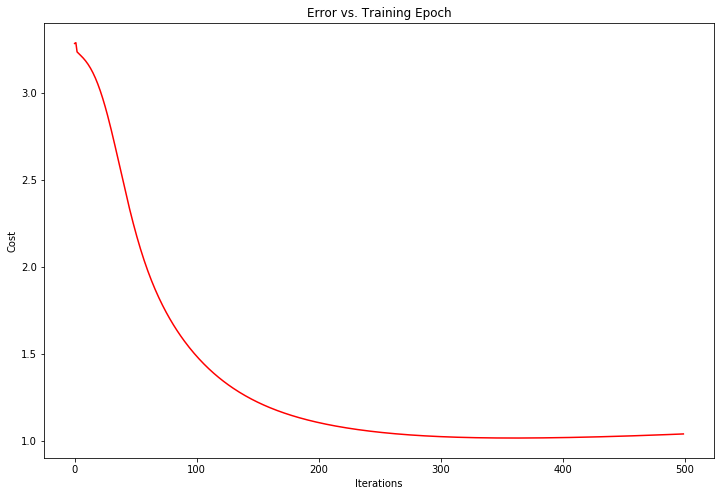

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(epoch), recorder_cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')
plt.show()

# accuracy

In [17]:
from sklearn.metrics import classification_report

_, _, _, _, h = forward(X, train_theta1, train_theta2)
y_pred = np.argmax(h, axis=1) + 1
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.94      0.93       500
           2       0.84      0.87      0.85       500
           3       0.84      0.88      0.86       500
           4       0.91      0.85      0.88       500
           5       0.90      0.74      0.81       500
           6       0.93      0.93      0.93       500
           7       0.94      0.87      0.90       500
           8       0.79      0.87      0.83       500
           9       0.86      0.89      0.87       500
          10       0.89      0.97      0.93       500

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

